# Modeling and Simulation in Python

Case study.

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Electric car

[Olin Electric Motorsports](https://www.olinelectricmotorsports.com/) is a club at Olin College that designs and builds electric cars, and participates in the [Formula SAE Electric](https://www.sae.org/attend/student-events/formula-sae-electric) competition.

The goal of this case study is to use simulation to guide the design of a car intended to accelerate from standing to 100 kph as quickly as possible.  The [world record for this event](https://www.youtube.com/watch?annotation_id=annotation_2297602723&feature=iv&src_vid=I-NCH8ct24U&v=n2XiCYA3C9s), using a car that meets the competition requirements, is 1.513 seconds.

We'll start with a simple model that takes into account the characteristics of the motor and vehicle:

* The motor is an [Emrax 228 high voltage axial flux synchronous permanent magnet motor](http://emrax.com/products/emrax-228/); according to the [data sheet](http://emrax.com/wp-content/uploads/2017/01/emrax_228_technical_data_4.5.pdf), its maximum torque is 240 Nm, at 0 rpm.  But maximum torque decreases with motor speed; at 5000 rpm, maximum torque is 216 Nm.

* The motor is connected to the drive axle with a chain drive with speed ratio 13:60 or 1:4.6; that is, the axle rotates once for each 4.6 rotations of the motor.

* The radius of the tires is 0.26 meters.

* The weight of the vehicle, including driver, is 300 kg.

To start, we will assume no slipping between the tires and the road surface, no air resistance, and no rolling resistance.  Then we will relax these assumptions one at a time.

* First we'll add drag, assuming that the frontal area of the vehicle is 0.6 square meters, with coefficient of drag 0.6.

* Next we'll add rolling resistance, assuming a coefficient of 0.2.

* Finally we'll compute the peak acceleration to see if the "no slip" assumption is credible.

We'll use this model to estimate the potential benefit of possible design improvements, including decreasing drag and rolling resistance, or increasing the speed ratio.

I'll start by loading the units we need.

In [2]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second
minute = UNITS.minute
hour = UNITS.hour
km = UNITS.kilometer
kg = UNITS.kilogram
N = UNITS.newton
rpm = UNITS.rpm

<Unit('revolutions_per_minute')>

And store the parameters in a `Params` object.

In [3]:
params = Params(r_wheel=0.26 * m,
                speed_ratio=13/60,
                C_rr=0.2,
                C_d=0.5,
                area=0.6*m**2,
                rho=1.2*kg/m**3,
                mass=300*kg)

,values
r_wheel,0.26 meter
speed_ratio,0.216667
C_rr,0.2
C_d,0.5
area,0.6 meter ** 2
rho,1.2 kilogram / meter ** 3
mass,300 kilogram


`make_system` creates the initial state, `init`, and constructs an `interp1d` object that represents torque as a function of motor speed.

In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object
    
    returns: System object
    """
    init = State(x=0*m, v=0*m/s)
    
    rpms = [0, 2000, 5000]
    torques = [240, 240, 216]
    interpolate_torque = interpolate(Series(torques, rpms))
    
    return System(params, init=init,
                  interpolate_torque=interpolate_torque,
                  t_end=3*s)

Testing `make_system`

In [5]:
system = make_system(params)

,values
r_wheel,0.26 meter
speed_ratio,0.216667
C_rr,0.2
C_d,0.5
area,0.6 meter ** 2
rho,1.2 kilogram / meter ** 3
mass,300 kilogram
init,x 0 meter v 0.0 meter / secon...
interpolate_torque,<function interpolate.<locals>.wrapper at 0x7f...
unit_torque,1.0 meter * newton


In [6]:
system.init

,values
x,0 meter
v,0.0 meter / second


### Torque and speed

The relationship between torque and motor speed is taken from the [Emrax 228 data sheet](http://emrax.com/wp-content/uploads/2017/01/emrax_228_technical_data_4.5.pdf).  The following functions reproduce the red dotted line that represents peak torque, which can only be sustained for a few seconds before the motor overheats.

In [11]:
def compute_torque(omega, system):
    """Maximum peak torque as a function of motor speed.
    
    omega: motor speed in radian/s
    system: System object
    
    returns: torque in Nm
    """
    factor = (1 * radian / s).to(rpm)
    x = magnitude(omega * factor)
    return system.interpolate_torque(x) * N * m

In [12]:
compute_torque(0*radian/s, system)

240.0 <Unit('meter * newton')>

In [13]:
omega = (5000 * rpm).to(radian/s)
compute_torque(omega, system)

216.0 <Unit('meter * newton')>

Plot the whole curve.

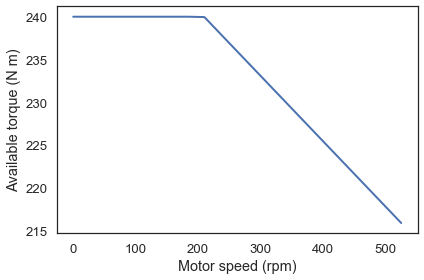

In [14]:
xs = linspace(0, 525, 21) * radian / s
taus = [compute_torque(x, system) for x in xs]
plot(xs, taus)
decorate(xlabel='Motor speed (rpm)',
         ylabel='Available torque (N m)')

### Simulation

Here's the slope function that computes the maximum possible acceleration of the car as a function of it current speed.

In [15]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object
    t: time
    system: System object 
    
    returns: sequence of derivatives
    """
    x, v = state
    r_wheel, speed_ratio = system.r_wheel, system.speed_ratio
    mass = system.mass
    
    # use velocity, v, to compute angular velocity of the wheel
    omega2 = v / r_wheel
    
    # use the speed ratio to compute motor speed
    omega1 = omega2 / speed_ratio
    
    # look up motor speed to get maximum torque at the motor
    tau1 = compute_torque(omega1, system)
    
    # compute the corresponding torque at the axle
    tau2 = tau1 / speed_ratio
    
    # compute the force of the wheel on the ground
    F = tau2 / r_wheel
    
    # compute acceleration
    a = F/mass

    return v, a      

Testing `slope_func` at linear velocity 10 m/s.

In [16]:
test_state = State(x=0*m, v=10*m/s)

,values
x,0 meter
v,10.0 meter / second


In [17]:
slope_func(test_state, 0*s, system)

(10.0 <Unit('meter / second')>, 14.201183431952662 <Unit('newton / kilogram')>)

Now we can run the simulation.

In [18]:
results, details = run_ode_solver(system, slope_func)
details

,values
success,True
message,The solver successfully reached the end of the...


And look at the results.

In [19]:
results.tail()

,x,v
2.88,57.32626824256294 meter,38.632749274430566 meter / second
2.91,58.49067227876934 meter,38.99375142852514 meter / second
2.94,59.66589334398368 meter,39.353885587648904 meter / second
2.97,60.851905429699734 meter,39.713153838812325 meter / second
3.00,62.0486825899462 meter,40.071558264007834 meter / second


After 3 seconds, the vehicle could be at 40 meters per second, in theory, which is 144 kph.

In [21]:
v_final = get_last_value(results.v)

40.071558264007834 <Unit('meter / second')>

In [22]:
v_final.to(km/hour)

144.2576097504282 <Unit('kilometer / hour')>

Plotting `x`

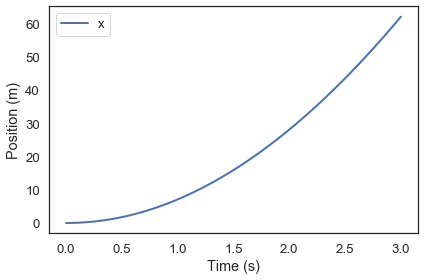

In [23]:
def plot_position(results):
    plot(results.x, label='x')
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

Plotting `v`

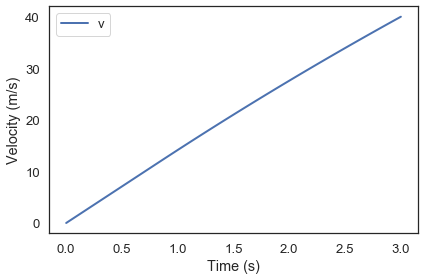

In [24]:
def plot_velocity(results):
    plot(results.v, label='v')
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

### Stopping at 100 kph

We'll use an event function to stop the simulation when we reach 100 kph.

In [25]:
def event_func(state, t, system):
    """Stops when we get to 100 km/hour.
    
    state: State object
    t: time
    system: System object 
    
    returns: difference from 100 km/hour
    """
    x, v = state
    
    # convert to km/hour
    factor = (1 * m/s).to(km/hour)
    v = magnitude(v * factor)
    
    return v - 100     

In [26]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
success,True
message,A termination event occurred.


Here's what the results look like.

Saving figure to file figs/chap11-fig02.pdf


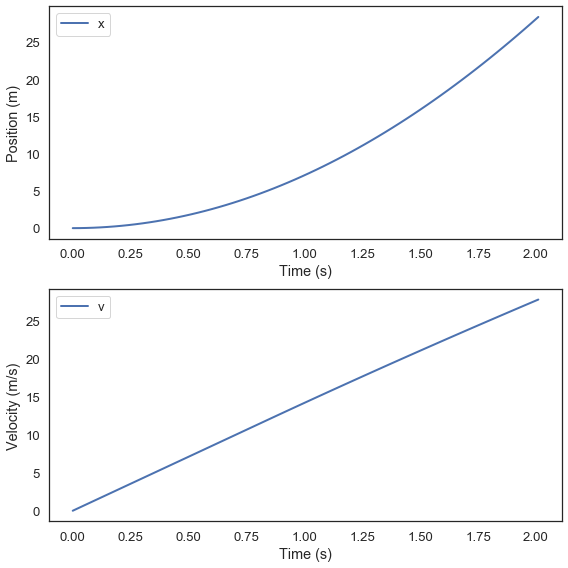

In [27]:
subplot(2, 1, 1)
plot_position(results)

subplot(2, 1, 2)
plot_velocity(results)

savefig('figs/chap11-fig02.pdf')

According to this model, we should be able to make this run in just over 2 seconds.

In [28]:
t_final = get_last_label(results) * s

2.010095574667565 <Unit('second')>

At the end of the run, the car has gone about 28 meters.

In [29]:
state = results.last_row()

,values
x,28.385825236293645 meter
v,27.777777777777775 meter / second


If we send the final state back to the slope function, we can see that the final acceleration is about 13 $m/s^2$, which is about 1.3 times the acceleration of gravity.

In [30]:
v, a = slope_func(state, 0, system)
v.to(km/hour)

99.99999999999999 <Unit('kilometer / hour')>

In [31]:
a

12.918946212080874 <Unit('newton / kilogram')>

In [32]:
g = 9.8 * m/s**2
(a / g).to(UNITS.dimensionless)

1.3182598175592728 <Unit('dimensionless')>

It's not easy for a vehicle to accelerate faster than `g`, because that implies a coefficient of friction between the wheels and the road surface that's greater than 1.  But racing tires on dry asphalt can do that; the OEM team at Olin has tested their tires and found a peak coefficient near 1.5.

So it's possible that our no slip assumption is valid, but only under ideal conditions, where weight is distributed equally on four tires, and all tires are driving.

**Exercise:** How much time do we lose because maximum torque decreases as motor speed increases?  Run the model again with no drop off in torque and see how much time it saves.

### Drag

In this section we'll see how much effect drag has on the results.

Here's a function to compute drag force, as we saw in Chapter 21.

In [33]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    system: System object
    
    returns: drag force
    """
    rho, C_d, area = system.rho, system.C_d, system.area
    
    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    return f_drag

We can test it with a velocity of 20 m/s.

In [34]:
drag_force(20 * m/s, system)

-72.0 <Unit('kilogram * meter / second ** 2')>

Here's the resulting acceleration of the vehicle due to drag.


In [35]:
drag_force(20 * m/s, system) / system.mass

-0.24 <Unit('meter / second ** 2')>

We can see that the effect of drag is not huge, compared to the acceleration we computed in the previous section, but it is not negligible.

Here's a modified slope function that takes drag into account.

In [36]:
def slope_func2(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object
    t: time
    system: System object 
    
    returns: sequence of derivatives
    """
    x, v = state
    r_wheel, speed_ratio = system.r_wheel, system.speed_ratio
    mass = system.mass
    
    omega2 = v / r_wheel * radian
    omega1 = omega2 / speed_ratio
    tau1 = compute_torque(omega1, system)
    tau2 = tau1 / speed_ratio
    F = tau2 / r_wheel
    a_motor = F / mass
    a_drag = drag_force(v, system) / mass
    
    a = a_motor + a_drag
    return v, a 

And here's the next run.

In [37]:
results2, details = run_ode_solver(system, slope_func2, events=event_func)
details

,values
success,True
message,A termination event occurred.


The time to reach 100 kph is a bit higher.

In [38]:
t_final2 = get_last_label(results2) * s

2.034354320417196 <Unit('second')>

But the total effect of drag is only about 2/100 seconds.

In [39]:
t_final2 - t_final

0.02425874574963105 <Unit('second')>

That's not huge, which suggests we might not be able to save much time by decreasing the frontal area, or coefficient of drag, of the car.

### Rolling resistance

Next we'll consider [rolling resistance](https://en.wikipedia.org/wiki/Rolling_resistance), which the force that resists the motion of the car as it rolls on tires.  The cofficient of rolling resistance, `C_rr`, is the ratio of rolling resistance to the normal force between the car and the ground (in that way it is similar to a coefficient of friction).

The following function computes rolling resistance.

In [40]:
system.set(unit_rr = 1 * N / kg)

In [41]:
def rolling_resistance(system):
    """Computes force due to rolling resistance.
    
    system: System object
    
    returns: force
    """
    return -system.C_rr * system.mass * system.unit_rr

The acceleration due to rolling resistance is 0.2 (it is not a coincidence that it equals `C_rr`).

In [42]:
rolling_resistance(system)

-60.0 <Unit('newton')>

In [43]:
rolling_resistance(system) / system.mass

-0.2 <Unit('newton / kilogram')>

Here's a modified slope function that includes drag and rolling resistance.

In [44]:
def slope_func3(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object
    t: time
    system: System object 
    
    returns: sequence of derivatives
    """
    x, v = state
    r_wheel, speed_ratio = system.r_wheel, system.speed_ratio
    mass = system.mass
    
    omega2 = v / r_wheel * radian
    omega1 = omega2 / speed_ratio
    tau1 = compute_torque(omega1, system)
    tau2 = tau1 / speed_ratio
    F = tau2 / r_wheel
    a_motor = F / mass
    a_drag = drag_force(v, system) / mass
    a_roll = rolling_resistance(system) / mass
    
    a = a_motor + a_drag + a_roll
    return v, a 

And here's the run.

In [45]:
results3, details = run_ode_solver(system, slope_func3, events=event_func)
details

,values
success,True
message,A termination event occurred.


The final time is a little higher, but the total cost of rolling resistance is only 3/100 seconds.

In [46]:
t_final3 = get_last_label(results3) * s

2.0646544476416953 <Unit('second')>

In [47]:
t_final3 - t_final2

0.030300127224499374 <Unit('second')>

So, again, there is probably not much to be gained by decreasing rolling resistance.

In fact, it is hard to decrease rolling resistance without also decreasing traction, so that might not help at all.

### Optimal gear ratio

The gear ratio 13:60 is intended to maximize the acceleration of the car without causing the tires to slip.  In this section, we'll consider other gear ratios and estimate their effects on acceleration and time to reach 100 kph.

Here's a function that takes a speed ratio as a parameter and returns time to reach 100 kph.

In [48]:
def time_to_speed(speed_ratio, params):
    """Computes times to reach 100 kph.
    
    speed_ratio: ratio of wheel speed to motor speed
    params: Params object
    
    returns: time to reach 100 kph, in seconds
    """
    params = Params(params, speed_ratio=speed_ratio)
    system = make_system(params)
    system.set(unit_rr = 1 * N / kg)
    
    results, details = run_ode_solver(system, slope_func3, events=event_func)
    t_final = get_last_label(results)
    a_initial = slope_func(system.init, 0, system)
    return t_final

We can test it with the default ratio:

In [49]:
time_to_speed(13/60, params)

2.0646544476416953

Now we can try it with different numbers of teeth on the motor gear (assuming that the axle gear has 60 teeth):

In [50]:
for teeth in linrange(8, 18):
    print(teeth, time_to_speed(teeth/60, params))

8 1.3230554808694261
9 1.4683740716590767
10 1.6154033363003908
11 1.763893473709603
12 1.913673186217739
13 2.0646544476416953
14 2.216761311453768
15 2.369962929121199
16 2.5242340753735495
17 2.6795453467447845


Wow!  The speed ratio has a big effect on the results.  At first glance, it looks like we could break the world record (1.513 seconds) just by decreasing the number of teeth.

But before we try it, let's see what effect that has on peak acceleration.

In [51]:
def initial_acceleration(speed_ratio, params):
    """Maximum acceleration as a function of speed ratio.
    
    speed_ratio: ratio of wheel speed to motor speed
    params: Params object
    
    returns: peak acceleration, in m/s^2
    """
    params = Params(params, speed_ratio=speed_ratio)
    system = make_system(params)
    a_initial = slope_func(system.init, 0, system)[1] * m/s**2
    return a_initial

Here are the results:

In [52]:
for teeth in linrange(8, 18):
    print(teeth, initial_acceleration(teeth/60, params))

8 23.076923076923077 meter * newton / kilogram / second ** 2
9 20.51282051282051 meter * newton / kilogram / second ** 2
10 18.46153846153846 meter * newton / kilogram / second ** 2
11 16.783216783216787 meter * newton / kilogram / second ** 2
12 15.384615384615385 meter * newton / kilogram / second ** 2
13 14.201183431952662 meter * newton / kilogram / second ** 2
14 13.186813186813184 meter * newton / kilogram / second ** 2
15 12.307692307692308 meter * newton / kilogram / second ** 2
16 11.538461538461538 meter * newton / kilogram / second ** 2
17 10.85972850678733 meter * newton / kilogram / second ** 2


As we decrease the speed ratio, the peak acceleration increases.  With 8 teeth on the motor gear, we could break the world record, but only if we can accelerate at 2.3 times the acceleration of gravity, which is impossible without very sticky ties and a vehicle that generates a lot of downforce.

In [53]:
23.07 / 9.8

2.354081632653061

These results suggest that the most promising way to improve the performance of the car (for this event) would be to improve traction.